In [87]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import os
import sys

sys.path.append("../../../")
import numpy as np
from scikit_posthocs import posthoc_dunn
from scipy.stats import kruskal

from src.athena import Athena
from src.utils import create_session

## Global

In [2]:
boto3_session = create_session(
    profile_name="dev",
    role_arn=os.getenv("ATHENA_IAM_ROLE_ARN"),
)

wait = True
ctas_approach = False
storage_format = "PARQUET"
write_compression = "SNAPPY"

database = "clique_bait"
tables = [
    "users",
    "events",
    "event_identifier",
    "campaign_identifier",
    "page_hierarchy",
]

athena = Athena(boto3_session=boto3_session, s3_output=os.getenv("ATHENA_S3_OUTPUT"))
athena

Athena(boto3_session=Session(region_name='us-east-1'), s3_output=s3://sql-case-studies/query_results)

## Problem Statement

Danny, the founder and CEO of Clique Bait, seeks to combine his expertise in digital data analytics with the seafood industry by creating an innovative online seafood store. To align with this vision, the analysis of available data is crucial to develop creative solutions for calculating funnel fallout rates for the Clique Bait online store. Gaining insights into where potential customers drop off in the sales funnel will be key to optimizing the user experience and enhancing conversion rates.

## Entity Relationship Diagram

<center>
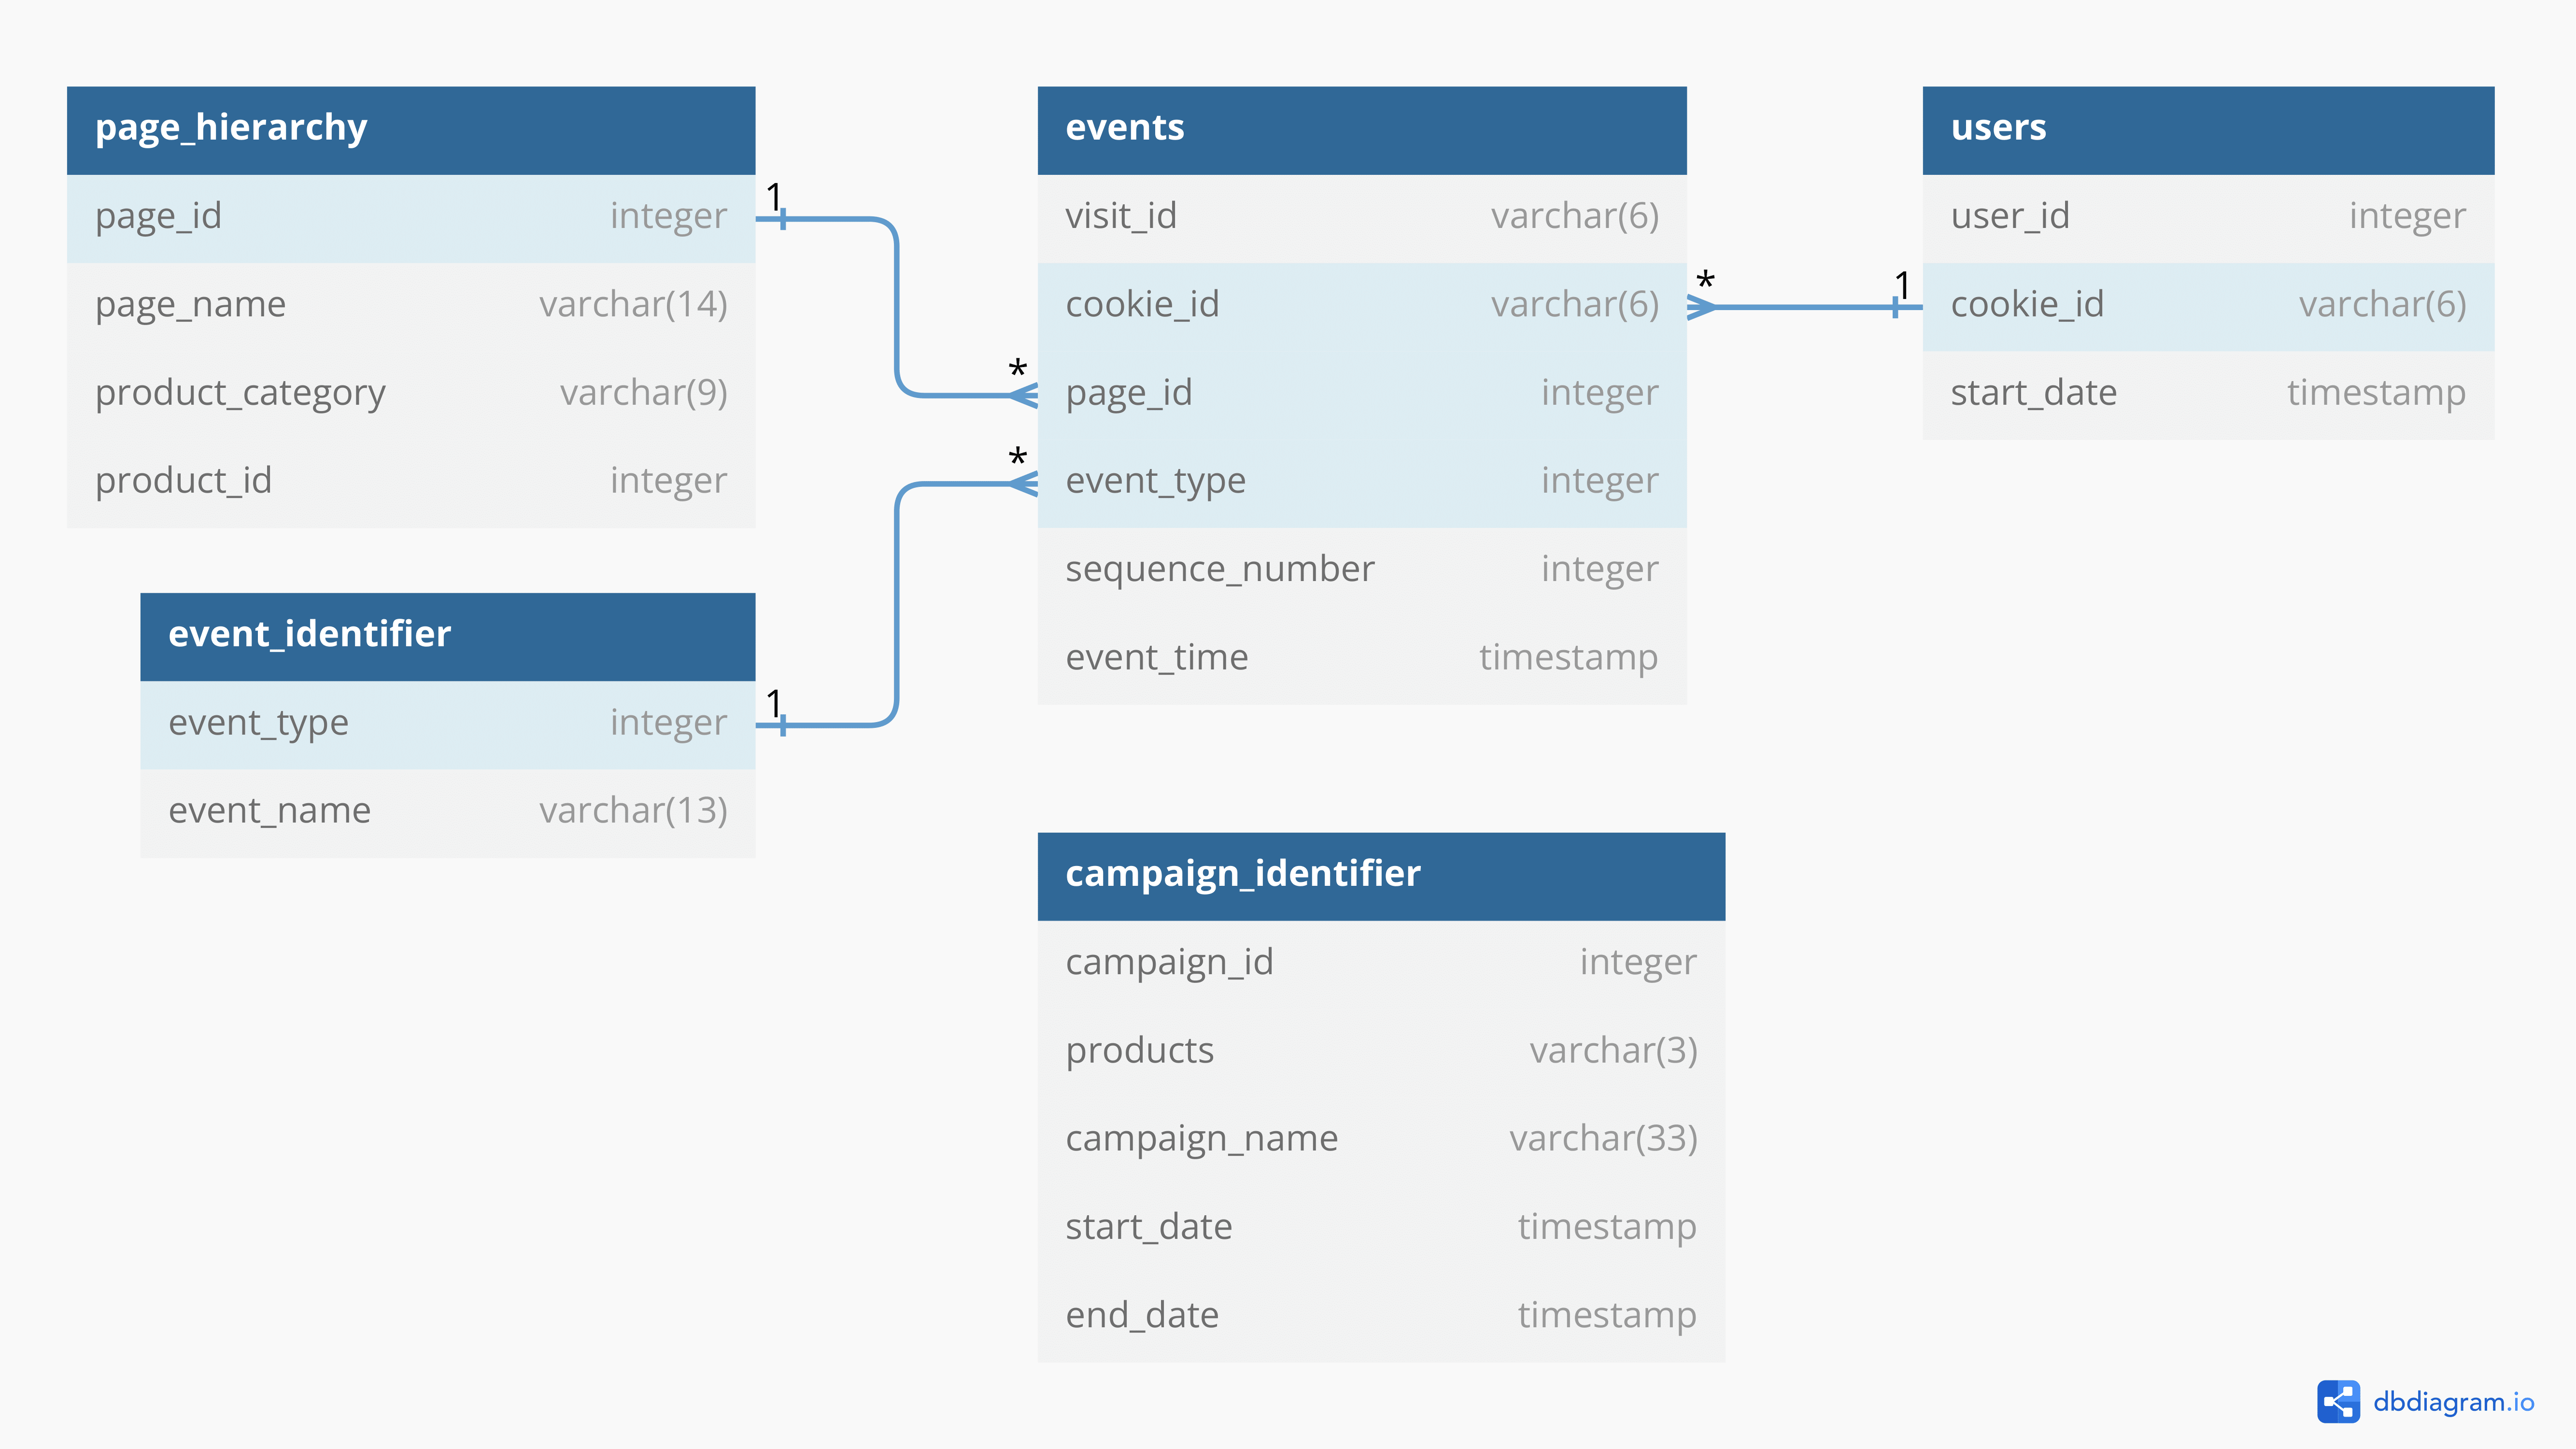
</center>

### Users 

This table logs the users who visit the Clique Bait website. Each user is identified by a `user_id` and is tagged via a `cookie_id`. The `start_date` indicates when the user first interacted with the website.

### Events Table

This table captures detailed logs of customer visits at the `cookie_id` level. Each event is recorded with a `visit_id`, `page_id`, `event_type`, and a `sequence_number` that orders the events within a visit. The `event_time` marks the timestamp of each interaction.

### Event Identifier Table

The event identifier table provides the names of the different types of events captured in the `Events` table. Each `event_type` corresponds to a specific `event_name`, such as Page View, Add to Cart, Purchase, etc.

### Campaign Identifier Table

This table contains information about the marketing campaigns run by Clique Bait in 2020. Each campaign is associated with a `campaign_id`, a list of `products`, a `campaign_name`, and the `start_date` and `end_date` of the campaign.

### Page Hierarchy Table

The page hierarchy table provides details on the website's structure. Each `page_id` is associated with a `page_name`, and in some cases, a `product_category` and `product_id`. This table helps in identifying the specific pages visited during user sessions.

## Tables

In [4]:
for table in tables:
    athena.query(
        database=database,
        query=f""" 
                SELECT
                    *
                FROM
                    {database}.{table} TABLESAMPLE BERNOULLI(50);
              """,
        ctas_approach=ctas_approach,
    )

,user_id,cookie_id,start_date
0,2,c81e72,2020-01-18
1,3,eccbc8,2020-02-21
2,4,a87ff6,2020-02-22
3,6,167909,2020-01-25
4,7,8f14e4,2020-02-09
...,...,...,...
891,392,863bdd,2020-02-15
892,24,f4b5e8,2020-02-10
893,191,e83169,2020-03-21
894,94,59511b,2020-03-22


,visit_id,cookie_id,page_id,event_type,sequence_number,event_time
0,ccf365,c4ca42,1,1,1,2020-02-04 19:16:09.182
1,ccf365,c4ca42,2,1,2,2020-02-04 19:16:17.358
2,ccf365,c4ca42,6,1,3,2020-02-04 19:16:58.454
3,ccf365,c4ca42,10,1,6,2020-02-04 19:18:11.605
4,ccf365,c4ca42,10,2,7,2020-02-04 19:19:10.570
...,...,...,...,...,...,...
16212,355a6a,87a4ba,8,2,12,2020-03-18 22:42:33.090
16213,355a6a,87a4ba,9,2,14,2020-03-18 22:43:57.155
16214,355a6a,87a4ba,11,1,16,2020-03-18 22:44:18.900
16215,355a6a,87a4ba,11,2,17,2020-03-18 22:45:12.670


,event_type,event_name
0,2,Add to Cart
1,3,Purchase
2,4,Ad Impression


,campaign_id,products,campaign_name,start_date,end_date
0,1,1-3,BOGOF - Fishing For Compliments,2020-01-01,2020-01-14
1,2,4-5,25% Off - Living The Lux Life,2020-01-15,2020-01-28
2,3,6-8,Half Off - Treat Your Shellf(ish),2020-02-01,2020-03-31


,page_id,page_name,product_category,product_id
0,1,Home Page,<NA>,<NA>
1,2,All Products,<NA>,<NA>
2,3,Salmon,Fish,1
3,4,Kingfish,Fish,2
4,5,Tuna,Fish,3
5,6,Russian Caviar,Luxury,4
6,7,Black Truffle,Luxury,5
7,8,Abalone,Shellfish,6
8,9,Lobster,Shellfish,7
9,10,Crab,Shellfish,8


## Digital Analysis

## Q1

How many users are there?

In [6]:
query = """ 
SELECT
    COUNT(DISTINCT user_id) AS user_count
FROM
    clique_bait.users;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,user_count
0,500


## Q2 

How many cookies does each user have on average?

### Verify Cookie ID Uniqueness

First, verify that each `cookie_id` is non-repeating for each `user_id`:

In [16]:
query = """ 
SELECT
    user_id,
    COUNT(DISTINCT cookie_id) AS cookie_distinct_count,
    COUNT(cookie_id) AS cookie_count
FROM
    clique_bait.users
GROUP BY
    user_id
HAVING
    COUNT(DISTINCT cookie_id) <> COUNT(cookie_id)
ORDER BY
    user_id;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,user_id,cookie_distinct_count,cookie_count


Check if any unique `cookie_id` is associated with multiple `user_id`s using a self join:

In [19]:
query = """ 
SELECT
    COUNT(DISTINCT user_id) AS user_count_per_cookie_id
FROM
    clique_bait.users
GROUP BY
    cookie_id
HAVING
    COUNT(DISTINCT user_id) > 1
ORDER BY
    user_count_per_cookie_id;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,user_count_per_cookie_id


Now, we can calculate the average number of cookies per user:

In [10]:
query = """ 
WITH cookie_counts AS (
    SELECT
        COUNT(DISTINCT cookie_id) AS cookie_count
    FROM
        clique_bait.users
    GROUP BY
        user_id  
)
SELECT
    AVG(cookie_count) AS avg_cookies_per_user
FROM
    cookie_counts;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,avg_cookies_per_user
0,3.564


## Q3

What is the unique number of visits by all users per month?

In [21]:
query = """ 
SELECT
    MONTH(event_time) AS month,
    COUNT(DISTINCT visit_id) AS visit_count
FROM
    clique_bait.events
GROUP BY
    MONTH(event_time)
ORDER BY
    month;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,month,visit_count
0,1,876
1,2,1488
2,3,916
3,4,248
4,5,36


## Q4

What is the number of events for each event type?

### Cookie ID & Visit ID

Examine the relationship between `cookie_id` and `visit_id`: 

In [23]:
query = """ 
SELECT
    cookie_id,
    COUNT(DISTINCT visit_id) AS visit_count_per_cookie_id
FROM
    clique_bait.events
GROUP BY
    cookie_id
ORDER BY
    visit_count_per_cookie_id DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,cookie_id,visit_count_per_cookie_id
0,d3d944,2
1,c81e72,2
2,3416a7,2
3,e36985,2
4,f457c5,2
...,...,...
1777,af9a20,2
1778,2ecd95,2
1779,2a532c,2
1780,97cf1d,2


In [24]:
query = """ 
SELECT
    visit_id,
    COUNT(DISTINCT cookie_id) AS cookie_count_per_visit_id
FROM
    clique_bait.events
GROUP BY
    visit_id
ORDER BY
    cookie_count_per_visit_id DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,visit_id,cookie_count_per_visit_id
0,f0e648,1
1,e6b166,1
2,b3518b,1
3,33395b,1
4,c3019e,1
...,...,...
3559,aa5d60,1
3560,0d2c3c,1
3561,ae568e,1
3562,ed9cb9,1


Cookie ID is one-to-many with Visit ID. 

To calculate the number of events for each event type, we can group the events by `event_type` and count the number of `visit_id`s without `DISTINCT`. This is because if there are multiple events of the same type within a visit, we want to count each event:

In [37]:
query = """ 
SELECT
    event_id.event_name AS event_name,
    events.event_type AS event_type,
    COUNT(events.visit_id) AS visit_count_per_event_type
FROM
    clique_bait.events AS events LEFT JOIN clique_bait.event_identifier AS event_id ON events.event_type = event_id.event_type
GROUP BY
    event_id.event_name, events.event_type
ORDER BY
    visit_count_per_event_type DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,event_name,event_type,visit_count_per_event_type
0,Page View,1,20928
1,Add to Cart,2,8451
2,Purchase,3,1777
3,Ad Impression,4,876
4,Ad Click,5,702


## Q5

What is the percentage of visits which have a purchase event?

Group by each `visit_id` and use `MAX` to return 1 if there was ever a purchase event in a visit. The `CASE` when returns 1 for all rows within a visit that are purchases, and `MAX` simply returns a 1 if there is at least one purchase event in a visit. For examples if a visit has had 2 add to carts and 2 purchases, then `[2, 2, 3, 3]` will result in `[0, 0, 1, 1]` and `MAX` will return 1.

**Note**: we use $1.0$ and $0.0$ instead of $1$ and $0$ to ensure that the division returns a double to avoid integer division downstream.

In [68]:
query = """ 
SELECT
    visit_id,
    MAX(CASE WHEN event_type = 3 THEN 1.0 ELSE 0.0 END) AS has_purchase_event
FROM 
    clique_bait.events
GROUP BY 
    visit_id;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,visit_id,has_purchase_event
0,e0ce49,1.0
1,a6c424,0.0
2,5ef346,0.0
3,d69e73,0.0
4,378a75,0.0
...,...,...
3559,f94f32,0.0
3560,672c30,1.0
3561,8e6c42,0.0
3562,8fb57b,0.0


To compute the percentage of unique visits with a purchase event, we sum the purchase boolean and divide by the total number of unique visits:

In [71]:
query = """ 
WITH visit_purchase AS (
    SELECT
        visit_id,
        MAX(CASE WHEN event_type = 3 THEN 1.0 ELSE 0.0 END) AS has_purchase_event
    FROM 
        clique_bait.events
    GROUP BY 
        visit_id
)
SELECT
    ROUND((SUM(has_purchase_event) / COUNT(*)) * 100, 4) AS purchase_pct
FROM
    visit_purchase;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,purchase_pct
0,49.8597


## Q6

What is the percentage of visits which view the checkout page but do not have a purchase event?


In the `page_hierarchy` table, the `page_id` for the checkout page is `12` and the `event_type` for viewing a page is `1` and `3` for a purchase event.

In [74]:
query = """ 
SELECT
    visit_id,
    MAX(CASE WHEN event_type = 1 AND page_id = 12 THEN 1.0 ELSE 0.0 END) AS has_checkout_view
    MAX(CASE WHEN event_type = 3 THEN 1.0 ELSE 0.0 END) AS has_purchase
FROM
    clique_bait.events
GROUP BY
    visit_id;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,visit_id,has_page_view,has_purchase
0,e0ce49,1.0,1.0
1,a6c424,0.0,0.0
2,5ef346,0.0,0.0
3,d69e73,1.0,0.0
4,378a75,0.0,0.0
...,...,...,...
3559,f94f32,0.0,0.0
3560,672c30,1.0,1.0
3561,8e6c42,0.0,0.0
3562,8fb57b,0.0,0.0


We also need to add a where filter to exclude visits that do not have checkout page views from the denominator:

In [81]:
query = """ 
WITH visit_purchase_page_view AS (
    SELECT
        visit_id,
        MAX(CASE WHEN event_type = 1 AND page_id = 12 THEN 1.0 ELSE 0.0 END) AS has_checkout_view,
        MAX(CASE WHEN event_type = 3 THEN 1.0 ELSE 0.0 END) AS has_purchase
    FROM
        clique_bait.events
    GROUP BY
        visit_id
)
SELECT
    ROUND((SUM(CASE WHEN has_checkout_view = 1.0 AND has_purchase = 0.0 THEN 1.0 ELSE 0.0 END) / COUNT(*)) * 100, 4) AS checkout_view_no_purchase_pct
FROM
    visit_purchase_page_view
WHERE
    has_checkout_view = 1.0;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,checkout_view_no_purchase_pct
0,15.5017


## Q7

What are the top 3 pages by number of views?

### Page ID & Visit ID

Examine the relationship between `page_id` and `visit_id`:

In [105]:
query = """ 
SELECT
    page_id,
    COUNT(DISTINCT visit_id) AS visit_distinct_count,
    COUNT(visit_id) AS visit_count
FROM
    clique_bait.events
GROUP BY
    page_id
HAVING
    COUNT(DISTINCT visit_id) <> COUNT(visit_id)
ORDER BY
    page_id;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,page_id,visit_distinct_count,visit_count
0,2,3174,4752
1,3,1559,2497
2,4,1559,2479
3,5,1515,2446
4,6,1563,2509
5,7,1469,2393
6,8,1525,2457
7,9,1547,2515
8,10,1564,2513
9,11,1568,2511


The above are all `page_id`s that have events that occurred within the same visit, hence the unique count and raw count of `visit_id`s are different.

However, if `event_type` is considered, then the distinct count of `visit_id` will be the same as the raw count of `visit_id`:

In [107]:
query = """ 
SELECT
    page_id,
    event_type,
    COUNT(DISTINCT visit_id) AS visit_distinct_count,
    COUNT(visit_id) AS visit_count
FROM
    clique_bait.events
GROUP BY
    page_id, event_type
HAVING
    COUNT(DISTINCT visit_id) <> COUNT(visit_id)
ORDER BY
    page_id;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,page_id,event_type,visit_distinct_count,visit_count


This means that `event_type`, `page_id`, and `visit_id` can be considered as a composite key.

In [111]:
query = """ 
SELECT
    page_id,
    visit_id,
    event_type,
    COUNT(*) AS count
FROM
    clique_bait.events
GROUP BY
    page_id, visit_id, event_type
ORDER BY
    count DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,page_id,visit_id,event_type,count
0,4,b7daee,1,1
1,3,83bfb0,2,1
2,6,b7daee,1,1
3,6,83bfb0,1,1
4,9,b7daee,2,1
...,...,...,...,...
32729,12,82dac8,1,1
32730,2,e73a2f,1,1
32731,2,aa1346,4,1
32732,2,aa1346,5,1


In [112]:
query = """ 
SELECT
    visit_id,
    page_id,
    event_type,
    COUNT(*) AS count
FROM
    clique_bait.events
GROUP BY
    visit_id, page_id, event_type
ORDER BY
    count DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,visit_id,page_id,event_type,count
0,b7daee,2,1,1
1,f3897a,7,1,1
2,b7daee,4,1,1
3,f3897a,12,1,1
4,b7daee,10,1,1
...,...,...,...,...
32729,c09cfd,4,2,1
32730,c09cfd,8,2,1
32731,355a6a,6,1,1
32732,355a6a,6,2,1


When considering only `visit_id` and `page_id`, the relationship is **many-to-many** since a visit can include multiple page views, and a page can be viewed in multiple visits. However, adding `event_type` to the combination enforces uniqueness, making the relationship **one-to-one** within that composite key.

In the query below, because of the filter for page view events `event_type = 1`, we can either use `COUNT(DISTINCT visit_id)` or `COUNT(visitor_id)` after group by `page_id` to calculate the number of views for each page. The result will be the same because controlling for `event_type` makes the relationship between `page_id` and `visit_id` one-to-one.

The top three pages by number of views are:

In [3]:
query = """ 
SELECT
    events.page_id AS page_id,
    pa.page_name AS page_name,
    COUNT(DISTINCT visit_id) AS num_views
FROM
    clique_bait.events AS events LEFT JOIN clique_bait.page_hierarchy AS pa ON events.page_id = pa.page_id
WHERE
    events.event_type = 1
GROUP BY
    events.page_id, pa.page_name
ORDER BY
    num_views DESC
LIMIT 
    3;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,page_id,page_name,num_views
0,2,All Products,3174
1,12,Checkout,2103
2,1,Home Page,1782


## Q8

What is the number of views and cart adds for each product category?

In [116]:
query = """ 
SELECT
    pa.product_category AS product_cat,
    SUM(CASE WHEN events.event_type = 1 THEN 1 ELSE 0 END) AS page_views,
    SUM(CASE WHEN events.event_type = 2 THEN 1 ELSE 0 END) AS cart_adds
FROM 
    clique_bait.events AS events LEFT JOIN clique_bait.page_hierarchy AS pa ON events.page_id = pa.page_id
WHERE
    pa.product_category IS NOT NULL
GROUP BY
    pa.product_category
ORDER BY
    pa.product_category;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,product_cat,page_views,cart_adds
0,Fish,4633,2789
1,Luxury,3032,1870
2,Shellfish,6204,3792


## Q9

What are the top 3 products by add to cart followed by purchase events?

In [134]:
query = """ 
SELECT
    event_type,
    COUNT(DISTINCT visit_id) AS visit_distinct_count,
    COUNT(visit_id) AS visit_count
FROM
    clique_bait.events
GROUP BY
    event_type;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,event_type,visit_distinct_count,visit_count
0,1,3564,20928
1,2,2510,8451
2,4,876,876
3,5,702,702
4,3,1777,1777


Controlling for `event_type = 3` (i.e., a purchase event), `event_type` and `visit_id` are one-to-one, we can confidently and simply select `visit_id` in the `purchase_visit_ids` CTE without needing `DISTINCT`. This ensures that we efficiently identify all unique visits that resulted in a purchase.

In the main query, we use `SUM(CASE WHEN events.event_type = 2 THEN 1 ELSE 0 END)` to count the number of "add to cart" events (`event_type = 2`) for each product. This aggregation is specifically focused on visits that included both "add to cart" and purchase actions.

The `WHERE EXISTS` clause then ensures that we only include "add to cart" events in the final count if they are associated with a visit that also resulted in a purchase. This filtering allows us to analyze the relationship between adding items to the cart and completing a purchase, giving insight into user behavior during successful purchase journeys.

In [143]:
query = """ 
WITH purchase_visit_ids AS (
    SELECT
        visit_id
    FROM
        clique_bait.events
    WHERE 
        event_type = 3
)
SELECT
    pa.product_id AS product_id,
    pa.page_name AS product_name,
    SUM(CASE WHEN events.event_type = 2 THEN 1 ELSE 0 END) AS add_count_followed_by_purchase
FROM 
    clique_bait.events AS events LEFT JOIN clique_bait.page_hierarchy AS pa ON events.page_id = pa.page_id
WHERE 
    EXISTS (
        SELECT 
            NULL
        FROM 
            purchase_visit_ids AS pvids
        WHERE 
            events.visit_id = pvids.visit_id
    )
AND 
    pa.product_id IS NOT NULL
GROUP BY 
    pa.product_id, 
    pa.page_name
ORDER BY 
    SUM(CASE WHEN events.event_type = 2 THEN 1 ELSE 0 END) DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,product_id,product_name,add_count_followed_by_purchase
0,7,Lobster,754
1,9,Oyster,726
2,8,Crab,719
3,1,Salmon,711
4,5,Black Truffle,707
5,2,Kingfish,707
6,6,Abalone,699
7,3,Tuna,697
8,4,Russian Caviar,697


## Product Funnel Analysis

### Product Funnel View

Create a view that contains the following information:

* How many times was each product viewed?

* How many times was each product added to cart?

* How many times was each product added to a cart but not purchased (abandoned)?

* How many times was each product purchased?


#### Page Views & Cart Adds CTE

The first CTE groups by `visit_id`, `product_id`/`product_name`, and `product_category` to count the number of page views and cart adds for each combination of these dimensions. 

All events that are associated with non-product pages are filtered out, focusing only on interactions related to specific products where `product_id` is not null.

In [68]:
query = """ 
SELECT
    events.visit_id AS visit_id,
    pa.product_id AS product_id,
    pa.page_name AS product_name,
    pa.product_category AS product_cat,
    SUM(CASE WHEN event_type = 1 THEN 1 ELSE 0 END) AS page_view,
    SUM(CASE WHEN event_type = 2 THEN 1 ELSE 0 END) AS cart_add
FROM
    clique_bait.events AS events LEFT JOIN clique_bait.page_hierarchy AS pa ON events.page_id = pa.page_id
WHERE
    pa.product_id IS NOT NULL
GROUP BY
    events.visit_id, pa.product_id, pa.page_name, pa.product_category;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,visit_id,product_id,product_name,product_cat,page_view,cart_add
0,12e324,1,Salmon,Fish,1,0
1,b920d5,7,Lobster,Shellfish,1,1
2,7ba9e0,4,Russian Caviar,Luxury,1,1
3,7ba9e0,6,Abalone,Shellfish,1,1
4,7ba9e0,7,Lobster,Shellfish,1,0
...,...,...,...,...,...,...
13864,c09cfd,7,Lobster,Shellfish,1,1
13865,355a6a,4,Russian Caviar,Luxury,1,1
13866,355a6a,5,Black Truffle,Luxury,1,1
13867,355a6a,6,Abalone,Shellfish,1,1


#### Product Purchase CTE

The second CTE identifies visits that resulted in a purchase event, grouping by `visit_id`, `product_id`/`product_name`, and `product_category` to count the number of purchases for each product. 

Again, we do not need to use `DISTINCT` here since `visit_id` and `event_type` are one-to-one within the context of a purchase event.

In [31]:
query = """ 
SELECT
    visit_id
FROM
    clique_bait.events
WHERE 
    event_type = 3;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,visit_id
0,ccf365
1,9a2f24
2,f61ed7
3,e0ce49
4,8479c1
...,...
1772,b40bf5
1773,96b841
1774,672c30
1775,c09cfd


#### Combined CTE

The final CTE combines the results from the previous two CTEs, left joining the purchase events data onto the page views and cart adds data. 

In the combined table, if a visit in the `page_view_cart_add_cte` CTE did not result in a purchase, the `page_view_cart_add_cte.visit_id` would be non-null while the `purchase_cte.visit_id` column woud be null, which provides a way for us to determine which visits did and did no lead to a purchase.

We use a `CASE` statment to create a binary flag indicating whether a visit ultimately resulted in a purchase.

In [72]:
query = """ 
WITH page_view_cart_add_cte AS (
    SELECT
        events.visit_id AS visit_id,
        pa.product_id AS product_id,
        pa.page_name AS product_name,
        pa.product_category AS product_cat,
        SUM(CASE WHEN event_type = 1 THEN 1 ELSE 0 END) AS page_view,
        SUM(CASE WHEN event_type = 2 THEN 1 ELSE 0 END) AS cart_add
    FROM
        clique_bait.events AS events LEFT JOIN clique_bait.page_hierarchy AS pa ON events.page_id = pa.page_id
    WHERE
        pa.product_id IS NOT NULL
    GROUP BY
        events.visit_id, 
        pa.product_id, 
        pa.page_name, 
        pa.product_category
),
purchase_cte AS (
    SELECT
        visit_id
    FROM
        clique_bait.events
    WHERE 
        event_type = 3
)
SELECT  
    page_view_cart_add_cte.visit_id AS visit_id_page_view_cart_add_cte,
    purchase_cte.visit_id AS visit_id_purchase_cte,
    page_view_cart_add_cte.product_id AS product_id,
    page_view_cart_add_cte.product_name AS product_name,
    page_view_cart_add_cte.product_cat AS product_cat,
    page_view_cart_add_cte.page_view AS page_view,
    page_view_cart_add_cte.cart_add AS cart_add,
    CASE WHEN purchase_cte.visit_id IS NULL THEN 1 ELSE 0 END AS abandoned_purchase
FROM
    page_view_cart_add_cte LEFT JOIN purchase_cte ON page_view_cart_add_cte.visit_id = purchase_cte.visit_id;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,visit_id_page_view_cart_add_cte,visit_id_purchase_cte,product_id,product_name,product_cat,page_view,cart_add,abandoned_purchase
0,ccf365,ccf365,9,Oyster,Shellfish,1,1,0
1,d58cbd,<NA>,3,Tuna,Fish,1,1,1
2,9a2f24,9a2f24,9,Oyster,Shellfish,1,0,0
3,7caba5,<NA>,2,Kingfish,Fish,1,0,1
4,7caba5,<NA>,3,Tuna,Fish,1,1,1
...,...,...,...,...,...,...,...,...
13864,b40bf5,b40bf5,2,Kingfish,Fish,1,1,0
13865,b40bf5,b40bf5,7,Lobster,Shellfish,1,1,0
13866,96b841,96b841,2,Kingfish,Fish,1,1,0
13867,96b841,96b841,3,Tuna,Fish,1,1,0


#### Final View

The final product funnel view takes the combined CTE and aggregates the data, group by `product_id`/`product_name` and `product_category`.

In [80]:
query = """ 
CREATE OR REPLACE VIEW product_funnel AS 
WITH page_view_cart_add_cte AS (
    SELECT
        events.visit_id AS visit_id,
        pa.product_id AS product_id,
        pa.page_name AS product_name,
        pa.product_category AS product_cat,
        SUM(CASE WHEN event_type = 1 THEN 1 ELSE 0 END) AS page_view,
        SUM(CASE WHEN event_type = 2 THEN 1 ELSE 0 END) AS cart_add
    FROM
        clique_bait.events AS events LEFT JOIN clique_bait.page_hierarchy AS pa ON events.page_id = pa.page_id
    WHERE
        pa.product_id IS NOT NULL
    GROUP BY
        events.visit_id, 
        pa.product_id, 
        pa.page_name, 
        pa.product_category
),
purchase_cte AS (
    SELECT
        visit_id
    FROM
        clique_bait.events
    WHERE 
        event_type = 3
),
combined_cte AS (
    SELECT  
        page_view_cart_add_cte.visit_id AS visit_id_page_view_cart_add_cte,
        purchase_cte.visit_id AS visit_id_purchase_cte,
        page_view_cart_add_cte.product_id AS product_id,
        page_view_cart_add_cte.product_name AS product_name,
        page_view_cart_add_cte.product_cat AS product_cat,
        page_view_cart_add_cte.page_view AS page_view,
        page_view_cart_add_cte.cart_add AS cart_add,
        CASE WHEN purchase_cte.visit_id IS NULL THEN 1 ELSE 0 END AS abandoned_purchase
    FROM
        page_view_cart_add_cte LEFT JOIN purchase_cte ON page_view_cart_add_cte.visit_id = purchase_cte.visit_id
)
SELECT
    product_id,
    product_name,
    product_cat,
    SUM(page_view) AS page_views,
    SUM(cart_add) AS cart_adds,
    SUM(CASE WHEN cart_add = 1 AND abandoned_purchase = 1 THEN 1 ELSE 0 END) AS abandoned,
    SUM(CASE WHEN cart_add = 1 AND abandoned_purchase = 0 THEN 1 ELSE 0 END) AS purchases
FROM
    combined_cte
GROUP BY
    product_id,
    product_cat,
    product_name
ORDER BY
    product_id;
"""

athena.create_view(database=database, query=query, wait=wait)

Query executed successfully


In [81]:
query = """ 
SELECT
    *
FROM
    clique_bait.product_funnel;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,product_id,product_name,product_cat,page_views,cart_adds,abandoned,purchases
0,1,Salmon,Fish,1559,938,227,711
1,2,Kingfish,Fish,1559,920,213,707
2,3,Tuna,Fish,1515,931,234,697
3,4,Russian Caviar,Luxury,1563,946,249,697
4,5,Black Truffle,Luxury,1469,924,217,707
5,6,Abalone,Shellfish,1525,932,233,699
6,7,Lobster,Shellfish,1547,968,214,754
7,8,Crab,Shellfish,1564,949,230,719
8,9,Oyster,Shellfish,1568,943,217,726


### Product Category Funnel

To analyze the product funnel by category, we can further group the results by `product_category` in the final view.

In [84]:
query = """ 
CREATE OR REPLACE VIEW product_cat_funnel AS 
SELECT
    product_cat,
    SUM(page_views) AS page_views,
    SUM(cart_adds) AS cart_adds,
    SUM(abandoned) AS abandoned,
    SUM(purchases) AS purchases
FROM
    clique_bait.product_funnel
GROUP BY
    product_cat
ORDER BY
    product_cat;
"""

athena.create_view(database=database, query=query, wait=wait)

Query executed successfully


In [86]:
query = """ 
SELECT
    *
FROM
    clique_bait.product_cat_funnel;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,product_cat,page_views,cart_adds,abandoned,purchases
0,Fish,4633,2789,674,2115
1,Luxury,3032,1870,466,1404
2,Shellfish,6204,3792,894,2898


## Q1

Which product had the most views, cart adds and purchases?

In [92]:
query = """ 
WITH ranked_stats AS (
    SELECT
        product_id,
        product_name,
        page_views,
        cart_adds,
        purchases,
        RANK() OVER (ORDER BY page_views DESC NULLS LAST) AS page_views_rank,
        RANK() OVER (ORDER BY cart_adds DESC NULLS LAST) AS cart_adds_rank,
        RANK() OVER (ORDER BY purchases DESC NULLS LAST) AS purchases_rank
    FROM
        clique_bait.product_funnel
)
SELECT
    product_id,
    product_name,
    page_views,
    cart_adds,
    purchases,
    page_views_rank,
    cart_adds_rank,
    purchases_rank
FROM
    ranked_stats
WHERE
    page_views_rank = 1 
    OR cart_adds_rank = 1
    OR purchases_rank = 1;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,product_id,product_name,page_views,cart_adds,purchases,page_views_rank,cart_adds_rank,purchases_rank
0,7,Lobster,1547,968,754,6,1,1
1,9,Oyster,1568,943,726,1,4,2


## Q2

Which product was most likely to be abandoned?

Because `purchases` and `abandoned` are both subsets of `cart_adds`, we can calculate the abandonment rate as the ratio of abandoned cart adds to total cart adds:

In [98]:
query = """ 
SELECT
    product_name,
    ROUND(TRY_CAST(abandoned AS DOUBLE) / TRY_CAST(cart_adds AS DOUBLE), 4) AS fallout_rate
FROM
    clique_bait.product_funnel
ORDER BY
    fallout_rate DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,product_name,fallout_rate
0,Russian Caviar,0.2632
1,Tuna,0.2513
2,Abalone,0.2500
3,Crab,0.2424
4,Salmon,0.2420
5,Black Truffle,0.2348
6,Kingfish,0.2315
7,Oyster,0.2301
8,Lobster,0.2211


## Q3

Which product had the highest view to purchase percentage?

In [99]:
query = """ 
SELECT
    product_name,
    ROUND(TRY_CAST(purchases AS DOUBLE) / TRY_CAST(page_views AS DOUBLE), 4) AS view_to_purchase_rate
FROM
    clique_bait.product_funnel
ORDER BY
    view_to_purchase_rate DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,product_name,view_to_purchase_rate
0,Lobster,0.4874
1,Black Truffle,0.4813
2,Oyster,0.4630
3,Tuna,0.4601
4,Crab,0.4597
5,Abalone,0.4584
6,Salmon,0.4561
7,Kingfish,0.4535
8,Russian Caviar,0.4459


## Q4

What is the average conversion rate from view to cart add?

We will sum the total page views and car adds and then apply the division to calculate a single metric that proxies for the *average* conversion rate from view to cart add. This is because we should not average ratios that have different denominators (i.e., page views) even if the they are similarly sized across products.

In [106]:
query = """ 
SELECT
    ROUND(TRY_CAST(SUM(cart_adds) AS DOUBLE) / TRY_CAST(SUM(page_views) AS DOUBLE), 4) AS view_to_cart_add_rate
FROM
    clique_bait.product_funnel;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,view_to_cart_add_rate
0,0.6093


## Q5

What is the average conversion rate from cart add to purchase?

In [4]:
query = """ 
SELECT
    ROUND(TRY_CAST(SUM(purchases) AS DOUBLE) / TRY_CAST(SUM(cart_adds) AS DOUBLE), 4) AS cart_add_to_purchase_rate
FROM
    clique_bait.product_funnel;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,cart_add_to_purchase_rate
0,0.7593


## Campaigns Analysis

### Cart Products

This field is a comma separated text field with products added to the cart sorted by the order they were added to the cart.

First, we need to dynamically figure out the maximum range for `sequence_number` among all visits. This will allow us to generate a sequence of numbers from 1 to the maximum range, which we can then use to reshape `page_name` (i.e., `product_name`) into separate columns.

In [3]:
query = """ 
SELECT 
    DISTINCT sequence_number
FROM
    clique_bait.events
ORDER BY
    sequence_number;
"""

distinct_seq_nums = athena.query(
    database=database, query=query, ctas_approach=ctas_approach
)["sequence_number"].values

distinct_seq_nums

<IntegerArray>
[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
 20, 21, 22, 23]
Length: 23, dtype: Int32

Next, create `MAX(CASE WHEN ...)` statements for the entire range of `sequence_number` values; these are used to reshape the long format of products to a wide format where each product is in its own column.

In addition, we also generate a `products_cols` string containing comma separated column names for the products. This will be used in the final query to select the columns dynamically.

In [83]:
select_clauses = []
for seq_num in distinct_seq_nums:
    select_clauses.append(
        f"MAX(CASE WHEN seq_num = {seq_num} THEN product_name END) AS product_added_{seq_num}"
    )

select_clause = ",\n    ".join(select_clauses)

print(select_clause)

MAX(CASE WHEN seq_num = 1 THEN product_name END) AS product_added_1,
    MAX(CASE WHEN seq_num = 2 THEN product_name END) AS product_added_2,
    MAX(CASE WHEN seq_num = 3 THEN product_name END) AS product_added_3,
    MAX(CASE WHEN seq_num = 4 THEN product_name END) AS product_added_4,
    MAX(CASE WHEN seq_num = 5 THEN product_name END) AS product_added_5,
    MAX(CASE WHEN seq_num = 6 THEN product_name END) AS product_added_6,
    MAX(CASE WHEN seq_num = 7 THEN product_name END) AS product_added_7,
    MAX(CASE WHEN seq_num = 8 THEN product_name END) AS product_added_8,
    MAX(CASE WHEN seq_num = 9 THEN product_name END) AS product_added_9,
    MAX(CASE WHEN seq_num = 10 THEN product_name END) AS product_added_10,
    MAX(CASE WHEN seq_num = 11 THEN product_name END) AS product_added_11,
    MAX(CASE WHEN seq_num = 12 THEN product_name END) AS product_added_12,
    MAX(CASE WHEN seq_num = 13 THEN product_name END) AS product_added_13,
    MAX(CASE WHEN seq_num = 14 THEN product_nam

In [86]:
product_cols = ", ".join(
    [f"product_added_{i}" for i in range(1, len(distinct_seq_nums) + 1)]
)

print(product_cols)

product_added_1, product_added_2, product_added_3, product_added_4, product_added_5, product_added_6, product_added_7, product_added_8, product_added_9, product_added_10, product_added_11, product_added_12, product_added_13, product_added_14, product_added_15, product_added_16, product_added_17, product_added_18, product_added_19, product_added_20, product_added_21, product_added_22, product_added_23


The final steps are as follows:

1. The first CTE selects the distinct `visit_id` and filters for cart add events, sorting by `visit_id` and then by `sequence_number` to ensure that the products ordered based on when the user added them to the cart per visit.

2. The second CTE reshapes the long format of products into a wide format, creating a separate column for each product based on the `sequence_number` value. The `MAX(CASE WHEN ...)` statements are used to pivot the data. If a product exists at a specific `sequence_number`, it is placed in the corresponding column, otherwise, it is left as `NULL`.

<center>

| visit_id | seq_num | product_name |
|----------|---------|--------------|
| 1        | 3       | A            |
| 1        | 4       | B            |
| 2        | 2       | C            |
| 2        | 6       | D            |
| 2        | 7       | Z            |

</center>

<br>

<center>

| visit_id | product_1 | product_2 | product_3 | product_4 | product_5 | product_6 | product_7 |
|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
| 1        | NULL      | NULL      | A         | B         | NULL      | NULL      | NULL      |
| 2        | NULL      | C         | NULL      | NULL      | NULL      | D         | Z         |

</center>

3. The final query selects the `visit_id` and the reshaped product columns, concatenating all product columns into a single string field `cart_products` that contains the products added to the cart in the order they were added. The `CONCAT_WS` function is used to concatenate the product columns with a comma separator, which skips `NULL` values.

In [63]:
query = f""" 
WITH sorted_product AS (
    SELECT
        DISTINCT events.visit_id AS visit_id,
        events.sequence_number AS seq_num,
        pa.page_name AS product_name
    FROM
        clique_bait.events AS events LEFT JOIN clique_bait.page_hierarchy AS pa ON events.page_id = pa.page_id
    WHERE
        events.event_type = 2
    ORDER BY
        events.visit_id, events.sequence_number ASC
),
products_added_wide AS (
    SELECT
        visit_id,
        {select_clause}
    FROM 
        sorted_product
    GROUP BY
        visit_id
),
products_added AS (
    SELECT
        visit_id,
        CONCAT_WS(', ', {product_cols}) AS cart_products
    FROM
        products_added_wide
)
SELECT
    * 
FROM
    products_added;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,visit_id,cart_products
0,004aaf,"Tuna, Lobster"
1,01573b,"Black Truffle, Lobster"
2,019f19,"Russian Caviar, Abalone"
3,01cb19,Tuna
4,01db81,"Salmon, Crab"
...,...,...
2505,fe5061,"Tuna, Abalone"
2506,fe6c7e,Salmon
2507,fe9c1a,Lobster
2508,feb47c,"Salmon, Russian Caviar, Lobster, Crab"


The above data can then be left join onto the base `events` table downstream.

### Campaigns Metrics Table

We employ a CTAS (Create Table As Select) statement to store the results of the campaigns analysis as a new table:

<center>

| Column Name        | Description                                                                                         |
|--------------------|-----------------------------------------------------------------------------------------------------|
| `user_id`          | Unique identifier for the user.                                                                     |
| `visit_id`         | Unique identifier for each visit.                                                                   |
| `campaign_name`    | The name of the marketing campaign mapped to the visit if the `visit_start_time` falls within the campaign's start and end dates. |
| `visit_start_time` | The earliest event time recorded for each visit.                                                    |
| `purchases`        | A flag indicating whether a purchase was made during the visit (1 for yes, 0 for no).               |
| `cart_adds`        | Count of products added to the cart during the visit.                                               |
| `page_views`       | Count of page views during the visit.                                                               |
| `ad_impression`       | Count of ad impressions during the visit.                                                           |
| `ad_click`            | Count of ad clicks during the visit.                                                                |
| `cart_products`    | A comma-separated list of products added to the cart, sorted by the order they were added. |

</center>

In [15]:
query = f""" 
WITH sorted_product AS (
    SELECT
        DISTINCT events.visit_id AS visit_id,
        events.sequence_number AS seq_num,
        pa.page_name AS product_name
    FROM
        clique_bait.events AS events LEFT JOIN clique_bait.page_hierarchy AS pa ON events.page_id = pa.page_id
    WHERE
        events.event_type = 2
    ORDER BY
        events.visit_id, events.sequence_number ASC
),
products_added_wide AS (
    SELECT
        visit_id,
        {select_clause}
    FROM 
        sorted_product
    GROUP BY
        visit_id
),
products_added AS (
    SELECT
        visit_id,
        CONCAT_WS(', ', {product_cols}) AS cart_products
    FROM
        products_added_wide
)
SELECT
    users.user_id AS user_id,
    events.visit_id AS visit_id,
    camp_id.campaign_name,
    MIN(events.event_time) AS visit_start_time,
    MAX(CASE WHEN event_type = 3 THEN 1 ELSE 0 END) AS purchases,
    SUM(CASE WHEN event_type = 2 THEN 1 ELSE 0 END) AS cart_adds,
    SUM(CASE WHEN event_type = 1 THEN 1 ELSE 0 END) AS page_views,
    SUM(CASE WHEN event_type = 4 THEN 1 ELSE 0 END) AS ad_impressions,
    SUM(CASE WHEN event_type = 5 THEN 1 ELSE 0 END) AS ad_clicks,
    MAX(products_added.cart_products) AS cart_products
FROM
    clique_bait.events AS events 
        LEFT JOIN clique_bait.users AS users ON events.cookie_id = users.cookie_id
        LEFT JOIN products_added ON events.visit_id = products_added.visit_id
        LEFT JOIN clique_bait.campaign_identifier AS camp_id ON events.event_time BETWEEN camp_id.start_date AND camp_id.end_date
GROUP BY
    users.user_id,
    events.visit_id,
    camp_id.campaign_name
ORDER BY
    users.user_id,
    events.visit_id,
    visit_start_time ASC;
"""

athena.create_ctas_table(
    database=database,
    query=query,
    ctas_table="campaign_metrics",
    s3_output="s3://sql-case-studies/clique_bait/campaign_metrics/",
    storage_format=storage_format,
    write_compression=write_compression,
    wait=wait,
)

{'ctas_database': 'clique_bait',
 'ctas_table': 'campaign_metrics',
 'ctas_query_metadata': _QueryMetadata(execution_id='84ec31d6-3c27-4943-a0eb-3ff7cb828ef1', dtype={'rows': 'Int64'}, parse_timestamps=[], parse_dates=[], parse_geometry=[], converters={}, binaries=[], output_location='s3://sql-case-studies/clique_bait/campaign_metrics/tables/84ec31d6-3c27-4943-a0eb-3ff7cb828ef1', manifest_location='s3://sql-case-studies/clique_bait/campaign_metrics/tables/84ec31d6-3c27-4943-a0eb-3ff7cb828ef1-manifest.csv', raw_payload={'QueryExecutionId': '84ec31d6-3c27-4943-a0eb-3ff7cb828ef1', 'Query': 'CREATE TABLE "clique_bait"."campaign_metrics"\nWITH(\n    external_location = \'s3://sql-case-studies/clique_bait/campaign_metrics/campaign_metrics\',\n    write_compression = \'SNAPPY\',\n    format = \'PARQUET\')\nAS  \nWITH sorted_product AS (\n    SELECT\n        DISTINCT events.visit_id AS visit_id,\n        events.sequence_number AS seq_num,\n        pa.page_name AS product_name\n    FROM\n      

In [27]:
query = """ 
SELECT
    *
FROM
    clique_bait.campaign_metrics;
"""

campaign_metrics = athena.query(
    database=database, query=query, ctas_approach=ctas_approach
)

campaign_metrics

,user_id,visit_id,campaign_name,visit_start_time,purchases,cart_adds,page_views,ad_impressions,ad_clicks,cart_products
0,1,02a5d5,Half Off - Treat Your Shellf(ish),2020-02-26 16:57:26.260,0,0,4,0,0,<NA>
1,1,0826dc,Half Off - Treat Your Shellf(ish),2020-02-26 05:58:37.918,0,0,1,0,0,<NA>
2,1,0fc437,Half Off - Treat Your Shellf(ish),2020-02-04 17:49:49.602,1,6,10,1,1,"Tuna, Russian Caviar, Black Truffle, Abalone, ..."
3,1,30b94d,Half Off - Treat Your Shellf(ish),2020-03-15 13:12:54.023,1,7,9,1,1,"Salmon, Kingfish, Tuna, Russian Caviar, Abalon..."
4,1,41355d,Half Off - Treat Your Shellf(ish),2020-03-25 00:11:17.860,0,1,6,0,0,Lobster
...,...,...,...,...,...,...,...,...,...,...
3559,499,e6794c,<NA>,2020-01-29 04:55:55.745,1,4,8,0,0,"Russian Caviar, Abalone, Lobster, Crab"
3560,500,13668d,Half Off - Treat Your Shellf(ish),2020-02-28 02:16:14.963,1,5,8,1,1,"Salmon, Tuna, Russian Caviar, Abalone, Crab"
3561,500,29e5f8,Half Off - Treat Your Shellf(ish),2020-02-28 22:06:31.450,1,3,8,0,0,"Kingfish, Russian Caviar, Abalone"
3562,500,4cdfb7,Half Off - Treat Your Shellf(ish),2020-02-28 00:31:14.862,0,0,1,0,0,<NA>


## Summary Statistics

In [24]:
metrics = ["purchases", "cart_adds", "page_views", "ad_impressions", "ad_clicks"]

campaign_metrics.loc[:, metrics].describe(percentiles=[0.25, 0.5, 0.75, 0.95])

,purchases,cart_adds,page_views,ad_impressions,ad_clicks
count,3564.0,3564.0,3564.0,3564.0,3564.0
mean,0.498597,2.371212,5.872054,0.245791,0.19697
std,0.500068,2.233612,3.25593,0.430616,0.397765
min,0.0,0.0,1.0,0.0,0.0
25%,0.0,0.0,1.0,0.0,0.0
50%,0.0,2.0,7.0,0.0,0.0
75%,1.0,4.0,8.0,0.0,0.0
95%,1.0,7.0,10.0,1.0,1.0
max,1.0,9.0,12.0,1.0,1.0


## Impression & Purchase Rate

Does clicking on an impression lead to higher purchase rates?

In [44]:
query = """ 
WITH ad_metrics AS (
    SELECT 
        user_id,
        purchases,
        CASE 
            WHEN ad_impressions = 0 AND ad_clicks = 0 THEN 'no_impression_no_click' 
            WHEN ad_impressions > 0 AND ad_clicks = 0 THEN 'yes_impression_no_click' 
            WHEN ad_impressions > 0 AND ad_clicks > 0 THEN 'yes_impression_yes_click'
            ELSE 'other'
        END AS ad_groups
    FROM 
        clique_bait.campaign_metrics
)
SELECT
    ad_groups,
    SUM(purchases) AS purchases,
    COUNT(DISTINCT user_id) AS users,
    ROUND(TRY_CAST(SUM(purchases) AS double) / TRY_CAST(COUNT(DISTINCT user_id) AS double), 2) AS purchase_rate
FROM
    ad_metrics
GROUP BY
    ad_groups
ORDER BY
    purchase_rate DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,ad_groups,purchases,users,purchase_rate
0,no_impression_no_click,1040,500,2.08
1,yes_impression_yes_click,624,397,1.57
2,yes_impression_no_click,113,148,0.76


Holding impression to be non-zero, we see that the purchase rate is indeeded higher among user visits that involved an ad click. 

Interestingly, the group with zero impressions and zero clicks has the highest purchase rate relative to the other two groups--- non-zero impressions and zero clicks, and non-zero impressions and non-zero clicks. This may indicate that there are other factors at play that are not captured in the data, such as user intent or the quality of the ad content.

### Kruskal-Wallis Test

We can use the Kruskal-Wallis test to determine if there is a statistically significant difference median number of purchases among the three groups. The assumption of independent groups may not hold, but we can verify using visualizations and tests.

In [61]:
campaign_metrics["ad_groups"] = np.select(
    condlist=[
        (campaign_metrics["ad_impressions"] == 0)
        & (campaign_metrics["ad_clicks"] == 0),
        (campaign_metrics["ad_impressions"] > 0) & (campaign_metrics["ad_clicks"] == 0),
        (campaign_metrics["ad_impressions"] > 0) & (campaign_metrics["ad_clicks"] > 0),
    ],
    choicelist=[
        "no_impression_no_click",
        "yes_impression_no_click",
        "yes_impression_yes_click",
    ],
    default="other",
)

campaign_metrics["ad_groups"].value_counts()

ad_groups
no_impression_no_click      2688
yes_impression_yes_click     702
yes_impression_no_click      174
Name: count, dtype: int64

In [60]:
kruskal(
    campaign_metrics.loc[
        campaign_metrics["ad_groups"] == "no_impression_no_click", "purchases"
    ],
    campaign_metrics.loc[
        campaign_metrics["ad_groups"] == "yes_impression_no_click", "purchases"
    ],
    campaign_metrics.loc[
        campaign_metrics["ad_groups"] == "yes_impression_yes_click", "purchases"
    ],
)

KruskalResult(statistic=577.5451006662854, pvalue=3.86967832761235e-126)

Controlling Type-I error rate at any rate, we reject the null hypothesis that the median number of purchases is the same across all groups. 

### Dunn's Test for Multiple Comparisons

In [67]:
alpha = 0.01

posthoc_dunn(
    a=campaign_metrics, val_col="purchases", group_col="ad_groups", sort="bonferroni"
) < alpha

,no_impression_no_click,yes_impression_no_click,yes_impression_yes_click
no_impression_no_click,False,True,True
yes_impression_no_click,True,False,True
yes_impression_yes_click,True,True,False


## Campaign Success Metrics

In [81]:
query = """ 
WITH calculations AS (
    SELECT
        campaign_name,
        SUM(ad_impressions) AS total_impressions,
        SUM(ad_clicks) AS total_clicks,
        SUM(purchases) AS total_purchases,
        COUNT(visit_id) AS total_visits,
        COUNT(DISTINCT user_id) AS total_users,
        SUM(page_views) AS total_page_views,
        SUM(cart_adds) AS total_cart_adds
    FROM
        clique_bait.campaign_metrics
    GROUP BY
        campaign_name
)
SELECT
    COALESCE(campaign_name, 'No Campaign') AS campaign_name,
    COALESCE(TRY_CAST(total_clicks AS double) / TRY_CAST(total_impressions AS double), 0) * 100 AS click_through_rate,
    COALESCE(TRY_CAST(total_purchases AS double) / TRY_CAST(total_clicks AS double), 0) * 100 AS conversion_rate, 
    COALESCE(TRY_CAST(total_purchases AS double) / TRY_CAST(total_visits AS double), 0) * 100 AS purchase_rate,
    total_impressions,
    total_clicks,
    total_purchases,
    total_visits,
    total_users,
    total_page_views,
    total_cart_adds
FROM
    calculations
ORDER BY
    campaign_name;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,campaign_name,click_through_rate,conversion_rate,purchase_rate,total_impressions,total_clicks,total_purchases,total_visits,total_users,total_page_views,total_cart_adds
0,25% Off - Living The Lux Life,77.884615,249.382716,50.000000,104,81,202,404,160,2434,991
1,BOGOF - Fishing For Compliments,84.615385,230.909091,48.846154,65,55,127,260,103,1536,625
2,Half Off - Treat Your Shellf(ish),80.103806,254.859611,49.413735,578,463,1180,2388,449,13897,5592
3,No Campaign,79.844961,260.194175,52.343750,129,103,268,512,183,3061,1243


## Clean Up

In [88]:
athena.drop_view(database=database, view="product_cat_funnel", wait=wait)

athena.drop_view(database=database, view="product_funnel", wait=wait)

Query executed successfully


In [89]:
athena.drop_table(database=database, table="campaign_metrics", wait=wait)

Query executed successfully
